


## AI Summit Challenge by IndabaXKenya and DeKUT
Classify text from university students in Kenya towards a mental health chatbot

###### Mount your google colab drive

You can also skip this if you are uploading your data manually. Remember to edit the Paths

In [ ]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install pynvml

###### About Blurr

[Blurr](https://github.com/ohmeow/blurr) is a library that extends the Fastai library to provide additional functionality for working with Transformers-based models for Natural Language Processing (NLP) tasks.

Some of the features of Blurr include:

* Support for various NLP tasks such as text classification, sequence labeling, and question-answering using pre-trained Transformer models like BERT, RoBERTa, etc.
* Convenience functions for loading data, preprocessing, and fine-tuning pre-trained models.
* Specialized training and validation callbacks for working with Transformer models in Fastai.


###### Installations.

* Install FastAI
* Install Blurr

In [ ]:
!pip install huggingface_hub["fastai"] -qq

In [ ]:
! git clone https://github.com/ohmeow/blurr.git

fatal: destination path 'blurr' already exists and is not an empty directory.


###### CD into Blurr to manage installations.

In [ ]:
%cd /content/blurr

/content/blurr


In [ ]:
!pip install -e ".[dev]" -qq

  Preparing metadata (setup.py) ... done


###### Import Libraries

In [ ]:
import torch
import transformers
from fastai.text.all import *
import gc


from blurr.text.data.all import *
from blurr.text.modeling.all import *
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

### Config

In [ ]:

class CFG :
  path = "/content/drive/MyDrive/mental_health/"
  project_name = 'mental_health_classification_challenge'
  model_nm = "microsoft/deberta-base"

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  seed = 42
  train_name = 'Train.csv'
  test_name = 'Test.csv'
  label_mappings = None
  batch_size = 8
  max_length = 196
  num_classes = 4
  dropout = 0.0
  _valley = 5.248074739938602e-05
  num_epochs = 4
  model_cls = transformers.AutoModelForSequenceClassification
  n_splits = 10

###### Set Seed.

In [ ]:
 def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value)
# cpu  vars
    random.seed(seed_value)
 # Python
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
# gpu vars
        torch.backends.cudnn.deterministic = True
 #needed
        torch.backends.cudnn.benchmark = False
#Remember to use num_workers=0 when creating the DataBunch.

In [ ]:
random_seed(CFG.seed,True)

Check out FastAI

In [ ]:

import fastai
fastai.__version__

'2.7.12'

In [ ]:
torch.cuda.is_available()

True

###### Loading up your Data

Remember to edit the Paths!!!!!!

In [ ]:
train = pd.read_csv(CFG.path + CFG.train_name)
test = pd.read_csv(CFG.path + CFG.test_name)

display(train.head(), test.head())

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial support in school,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depression?,Depression


,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength to continue
3,0EPULUM5,I feel so low especially since I had no one to talk to
4,0GM4C5GD,can i be successful when I am a drug addict?


In [ ]:
test.shape

(309, 2)

* Filter the punct sub we already made , because its easy for a model to predict the punct but its goin to be so hard for the  model to predict the pos of different languages

In [ ]:
train.shape

(616, 3)

In [ ]:
def preprocess(df, text_col, target_col= None,id_col= None ):
    # Rename columns if necessary
    if text_col != 'inputs':
        df.rename(columns={text_col: 'inputs'}, inplace=True)
    if target_col:
        if target_col != 'target':
            df.rename(columns={target_col: 'label'}, inplace=True)
    if id_col:
        if id_col != 'id':
            df.rename(columns={id_col: 'id'}, inplace=True)


    df['Character Count'] = df['inputs'].apply(lambda x: len(str(x)))

    return df



train = preprocess(df=train,text_col='text',target_col='label',id_col='ID')
test = preprocess(df=test,text_col='text',target_col='label',id_col='ID')


In [ ]:
test['Character Count'].max()

166

In [ ]:
train.label.nunique()

4

In [ ]:
# train.rename(columns={'target': 'label'}, inplace=True)
train =train[['inputs','label']]
train = train.dropna()

train.head()

,inputs,label
0,I feel that it was better I dieAm happy,Depression
1,Why do I get hallucinations?,Drugs
2,I am stresseed due to lack of financial support in school,Depression
3,Why is life important?,Suicide
4,How could I be helped to go through the depression?,Depression


In [ ]:

train['label'] = le.fit_transform(train['label'])
CFG.label_mappings = dict(zip(le.classes_, le.transform(le.classes_)))
print(CFG.label_mappings)

{'Alcohol': 0, 'Depression': 1, 'Drugs': 2, 'Suicide': 3}


### Cross Validation

In [ ]:

train = train.sample(frac=1, random_state=42).reset_index(drop=True)
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle = True , random_state = CFG.seed)


train['fold'] = -1

for fold, (_, test_index) in enumerate(kf.split(train, train['label'])):
    train.loc[test_index, 'fold'] = fold





In [ ]:
# train.groupby('fold')['label'].value_counts()

In [ ]:
train.label.value_counts()

1    352
0    140
3     66
2     58
Name: label, dtype: int64

###### Training.

###### Setting Up the Datablock

Now that we've retrieved the needed configs, we manipulate this to create the Datablock to take advantage of the ease and functionality of FastAI.

As usual, the DataBlock API requires an input and output to form the block.

In our case, the input is created from FastAI's TextBlock class where we specify how the data(input text) is processed and tokenized leveraging the configs from HuggingFace. The Output is a Category block since we have a category of classes.

For the other params in the datablock, it is the standard convention.

1. get_x: how to get the data from dataframe
2. get_y: how to get the labels from dataframe
3. Splitter: how you want to split train and validation set.

After all said and done, we create the dataloader.

10 epochs

epoch,train_loss,valid_loss,accuracy,time
0,1.279102,0.994549,0.596774,00:12
1,0.858458,0.564120,0.790323,00:12
2,0.521952,0.481979,0.806452,00:13
3,0.382151,0.472390,0.806452,00:13


Better model found at epoch 0 with valid_loss value: 0.9945492148399353.
Better model found at epoch 1 with valid_loss value: 0.5641201734542847.
Better model found at epoch 2 with valid_loss value: 0.48197850584983826.
Better model found at epoch 3 with valid_loss value: 0.47238993644714355.


Processes before GC:
	GPU:0
process     166626 uses     4186.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2278.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_0.csv
Processes before GC:
	GPU:0
process     166626 uses     2278.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2278.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.139383,0.837875,0.709677,00:14
1,0.717453,0.367609,0.870968,00:13
2,0.425174,0.309060,0.887097,00:13
3,0.288558,0.310139,0.870968,00:13


Better model found at epoch 0 with valid_loss value: 0.8378754258155823.
Better model found at epoch 1 with valid_loss value: 0.3676086366176605.
Better model found at epoch 2 with valid_loss value: 0.3090604245662689.


Processes before GC:
	GPU:0
process     166626 uses     4174.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_1.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.168230,0.795744,0.725806,00:13
1,0.669875,0.305935,0.870968,00:13
2,0.399496,0.182422,0.967742,00:12
3,0.272366,0.191566,0.951613,00:12


Better model found at epoch 0 with valid_loss value: 0.7957437634468079.
Better model found at epoch 1 with valid_loss value: 0.3059350848197937.
Better model found at epoch 2 with valid_loss value: 0.18242208659648895.


Processes before GC:
	GPU:0
process     166626 uses     4172.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_2.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.144598,0.711401,0.741935,00:12
1,0.679605,0.331105,0.919355,00:12
2,0.380700,0.290455,0.903226,00:13
3,0.250211,0.271953,0.887097,00:13


Better model found at epoch 0 with valid_loss value: 0.7114007472991943.
Better model found at epoch 1 with valid_loss value: 0.33110538125038147.
Better model found at epoch 2 with valid_loss value: 0.2904554307460785.
Better model found at epoch 3 with valid_loss value: 0.2719527781009674.


Processes before GC:
	GPU:0
process     166626 uses     4174.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_3.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.116345,0.679590,0.758065,00:13
1,0.617897,0.417993,0.870968,00:13
2,0.350665,0.359616,0.870968,00:13
3,0.253585,0.355314,0.870968,00:13


Better model found at epoch 0 with valid_loss value: 0.6795904040336609.
Better model found at epoch 1 with valid_loss value: 0.4179927706718445.
Better model found at epoch 2 with valid_loss value: 0.3596157431602478.
Better model found at epoch 3 with valid_loss value: 0.35531386733055115.


Processes before GC:
	GPU:0
process     166626 uses     4172.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_4.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.172093,0.873317,0.741935,00:13
1,0.637890,0.508203,0.838710,00:13
2,0.366274,0.440384,0.870968,00:13
3,0.240751,0.449231,0.887097,00:13


Better model found at epoch 0 with valid_loss value: 0.8733174204826355.
Better model found at epoch 1 with valid_loss value: 0.5082027316093445.
Better model found at epoch 2 with valid_loss value: 0.4403839707374573.


Processes before GC:
	GPU:0
process     166626 uses     4166.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_5.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.159755,0.899950,0.606557,00:13
1,0.834150,0.539946,0.819672,00:13
2,0.503602,0.451523,0.836066,00:12
3,0.321910,0.419623,0.819672,00:12


Better model found at epoch 0 with valid_loss value: 0.8999501466751099.
Better model found at epoch 1 with valid_loss value: 0.5399457812309265.
Better model found at epoch 2 with valid_loss value: 0.45152270793914795.
Better model found at epoch 3 with valid_loss value: 0.419622540473938.


Processes before GC:
	GPU:0
process     166626 uses     4172.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_6.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.186331,0.815447,0.639344,00:12
1,0.745818,0.571210,0.836066,00:12
2,0.446912,0.415300,0.868852,00:13
3,0.274974,0.418880,0.868852,00:13


Better model found at epoch 0 with valid_loss value: 0.8154473900794983.
Better model found at epoch 1 with valid_loss value: 0.5712101459503174.
Better model found at epoch 2 with valid_loss value: 0.41529977321624756.


Processes before GC:
	GPU:0
process     166626 uses     4172.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_7.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.145533,0.765737,0.688525,00:13
1,0.742325,0.492632,0.819672,00:13
2,0.411209,0.419403,0.868852,00:13
3,0.261159,0.447623,0.836066,00:13


Better model found at epoch 0 with valid_loss value: 0.7657366394996643.
Better model found at epoch 1 with valid_loss value: 0.49263226985931396.
Better model found at epoch 2 with valid_loss value: 0.4194034934043884.


Processes before GC:
	GPU:0
process     166626 uses     4184.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2274.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_8.csv
Processes before GC:
	GPU:0
process     166626 uses     2274.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2274.000 MB GPU memory


epoch,train_loss,valid_loss,accuracy,time
0,1.189976,0.760070,0.737705,00:13
1,0.659814,0.317215,0.885246,00:13
2,0.353039,0.207258,0.918033,00:13
3,0.219381,0.200699,0.918033,00:13


Better model found at epoch 0 with valid_loss value: 0.7600699067115784.
Better model found at epoch 1 with valid_loss value: 0.3172145187854767.
Better model found at epoch 2 with valid_loss value: 0.2072584480047226.
Better model found at epoch 3 with valid_loss value: 0.20069874823093414.


Processes before GC:
	GPU:0
process     166626 uses     4172.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
309
Submission file saved: /content/drive/MyDrive/mental_health/fold_9.csv
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes before GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory
Processes after GC:
	GPU:0
process     166626 uses     2426.000 MB GPU memory


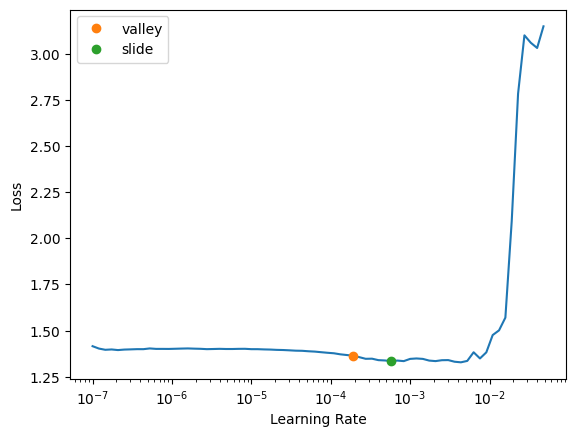

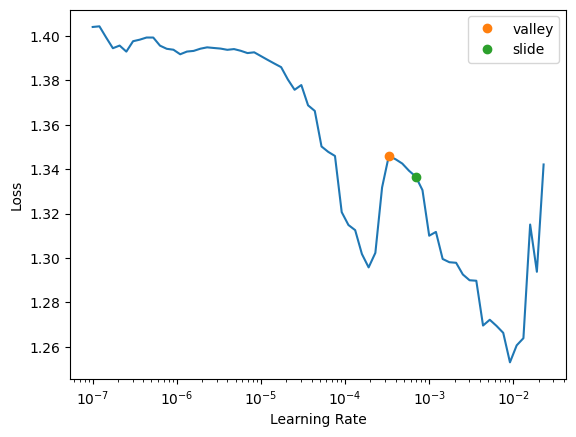

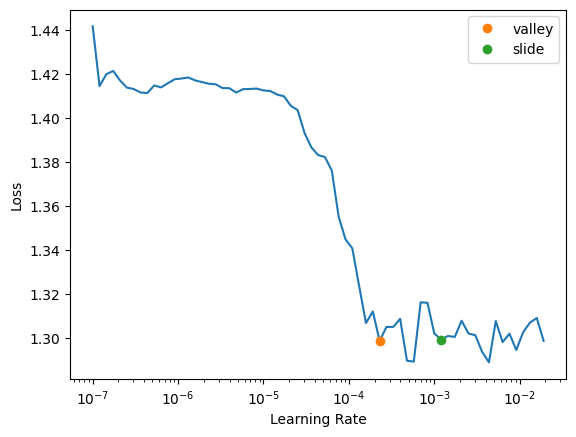

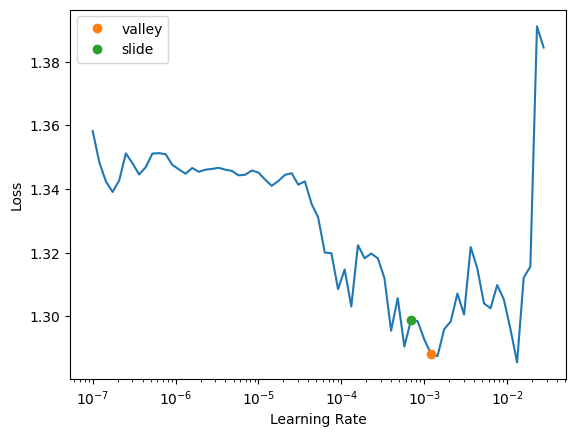

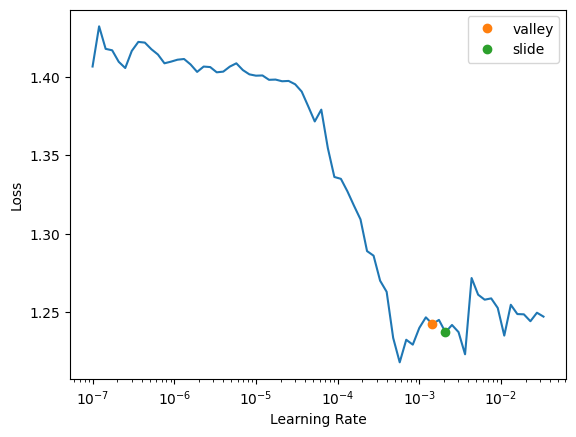

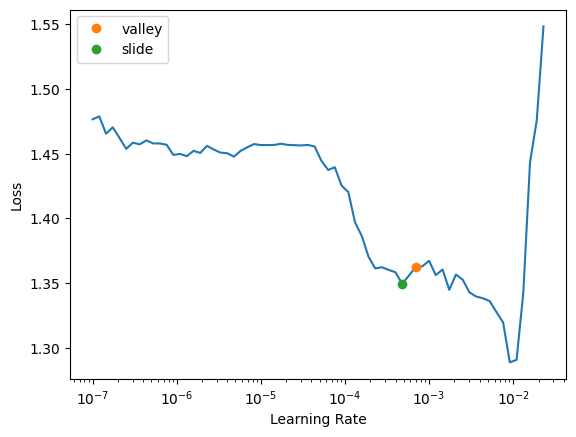

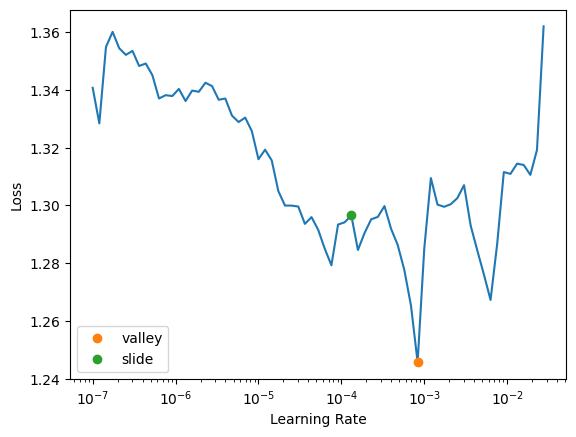

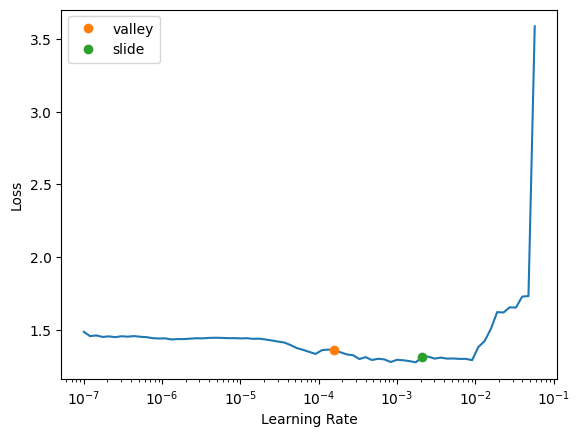

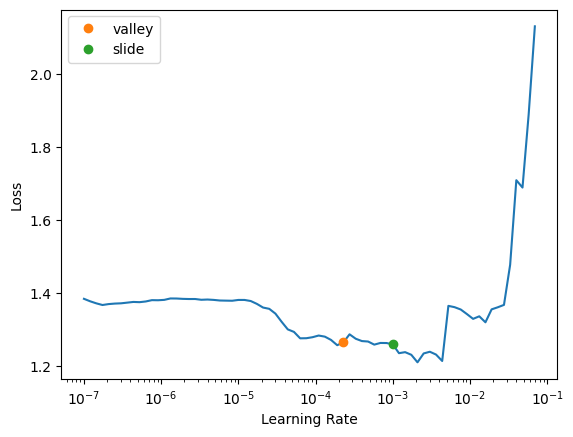

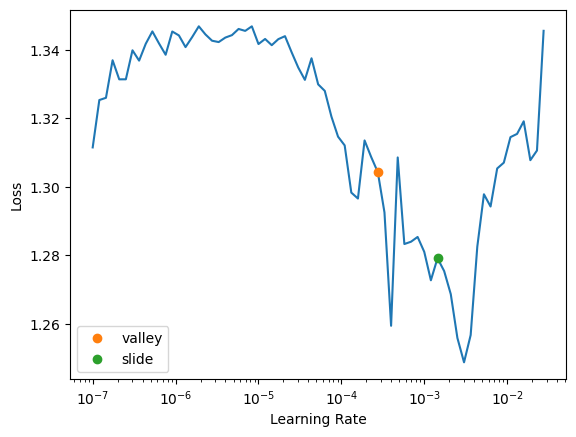

In [ ]:
valid_languages = [[0],[1], [2], [3], [4], [5], [6], [7], [8], [9]]


def generate_submission_file(valid_languages, preds, language_names):
    fold_name = '_'.join(str(lang) for lang in language_names)
    submission_file_name = f"fold_{fold_name}.csv"
    submission_file_path = os.path.join(CFG.path, submission_file_name)
    submission = pd.DataFrame()
    submission["id"] = test['id']
    k = np.unique(train.label).tolist()
    for i, c in enumerate(k):
        submission[c] = preds[:, i]

    {'Alcohol': 0, 'Depression': 1, 'Drugs': 2, 'Suicide': 3}

    submission = submission.rename(columns={0: 'Alcohol', 1: 'Depression', 2: 'Drugs', 3: 'Suicide'})
    submission = submission[['id','Depression','Alcohol','Suicide','Drugs']]
    submission.to_csv(submission_file_path, index=False)

    print(f"Submission file saved: {submission_file_path}")




def gc_gpu():
    print(f"Processes before GC:\n\t{torch.cuda.list_gpu_processes()}")
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Processes after GC:\n\t{torch.cuda.list_gpu_processes()}")

def train_with_cross_validation(train, valid_languages, test, fold_idx, hf_arch, hf_config, hf_tokenizer, hf_model, fine_tune = False):

    # The datablock
    train['is_valid'] = train['fold'].isin(valid_languages)
    blocks= (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model),
        CategoryBlock
         )
    # The datablock
    dblock = DataBlock(
        blocks=blocks,
        get_x=ColReader("inputs"),
        get_y=ColReader("label"),
        splitter=ColSplitter('is_valid')
    )


    # Creating the dataloader
    dls = dblock.dataloaders(train, bs=CFG.batch_size)

    # Creating the model
    model = BaseModelWrapper(hf_model)

    # Creating the learner
    learn = Learner(
        dls,
        model,
        opt_func=partial(Adam, decouple_wd=True),
        loss_func=CrossEntropyLossFlat(),
        metrics=[accuracy],
        cbs=[BaseModelCallback, SaveModelCallback(), ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2, min_lr=1e-8)],
    )
    if fine_tune:
      _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
      learn.fine_tune(CFG.num_epochs, _valley)
    else:
      learn.freeze()
      _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
      learn.fit_one_cycle(CFG.num_epochs, 2e-05)


    # Test predictions
    test_dl = learn.dls.test_dl(test['inputs'])
    preds,_ = learn.get_preds(dl=test_dl)
    # preds, _ = learn.get_preds(dl=test_dl, n=5)



    # Save model
    # model_name = f"{CFG.model_nm}_model_fold_{fold_idx + 1}_epochs_{CFG.num_epochs}.pkl"
    # learn.export(CFG.path + model_name)

    # Free GPU memory
    del(learn)
    gc_gpu()
    return preds


preds_list = []
for fold_idx, valid_language in enumerate(valid_languages):

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
      CFG.model_nm,
      model_cls=CFG.model_cls,
      config=transformers.AutoConfig.from_pretrained(CFG.model_nm, num_labels = CFG.num_classes, ignore_mismatched_sizes=True)
    )
    preds_fold = train_with_cross_validation(train = train, valid_languages = valid_language, test = test, fold_idx =fold_idx,
                                              hf_arch = hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, fine_tune=False, )

    preds_list.append(preds_fold)
    print(len(preds_fold))
    generate_submission_file(valid_language, preds_fold, valid_language)
    # Clear references and free GPU memory
    del preds_fold, hf_arch, hf_config, hf_tokenizer, hf_model
    gc_gpu()



# Calculate mean predictions
preds_mean = torch.stack(preds_list).mean(dim=0)


submission = pd.DataFrame()
submission["id"] = test['id']
k = np.unique(train.label).tolist()
for i, c in enumerate(k):
    submission[c] = preds_mean[:, i]
submission = submission.rename(columns={0: 'Alcohol', 1: 'Depression', 2: 'Drugs', 3: 'Suicide'})
submission = submission[['id','Depression','Alcohol','Suicide','Drugs']]
submission.to_csv(CFG.path + "mean_predictions.csv", index = False)
# Free GPU memory
gc_gpu()